# SeaTurtleIDHeads CNN Model


This notebook provides a CNN model using the [SeaTurtleIDHeads dataset](https://www.kaggle.com/datasets/wildlifedatasets/seaturtleidheads). We load the necessary packages first.

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import date
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from utils import load_dataframe, plot_grid
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.model_selection import train_test_split
import seaborn as sns

root_dir = '/kaggle/input/seaturtleidheads'

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 50
batch_size = 15
learning_rate = 0.001

In [3]:
# load data and investigate structure
df = load_dataframe(root_dir, img_type='heads')
print(df)

        id identity  position                 date                        path
0        0     t281   topleft  2016-07-11 16:53:31  images/t281/ILXxnZwvNh.JPG
1        1     t281     right  2016-07-11 16:53:13  images/t281/DjtwgIIURL.JPG
2        2     t281   topleft  2016-07-11 16:53:33  images/t281/hHfmOdhzDU.JPG
3        3     t281      left  2016-07-11 16:54:03  images/t281/gTovpgwOut.JPG
4        4     t281     right  2016-07-11 16:53:12  images/t281/yUETlrBYAp.JPG
...    ...      ...       ...                  ...                         ...
7577  7769     t157   topleft  2015-06-30 17:43:34  images/t157/onmATVzAyB.JPG
7578  7770     t157  topright  2015-06-30 17:42:46  images/t157/FQNPajeBYd.JPG
7579  7771     t157       top  2015-06-30 17:43:10  images/t157/cwXNsIVEFz.JPG
7580  7772     t157     right  2015-06-30 17:43:12  images/t157/blzCVWUqSI.JPG
7581  7773     t157  topright  2015-06-30 17:43:50  images/t157/GlAcIiUGqN.JPG

[7582 rows x 5 columns]


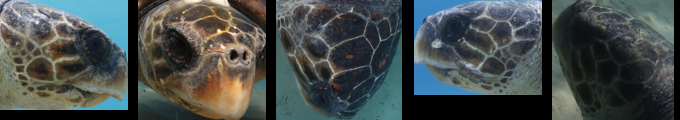

In [4]:
# create a subset of data
subset_df = df[df['identity'].isin(['t023', 't025', 't033', 't034',
                                    't073', 't094', 't204', 't217',
                                    't243', 't323'])]

subset_df = subset_df.reset_index(drop=True)

# sample of subset data
plot_grid(df[(df['identity'] == 't094')], root_dir, n_cols=5, n_rows=1, img_min=120)


In [5]:
def split(data, date_col_name='', split_date = '' , time_cutoff=False):
    
    """
    Splits data frame with either time cutoff or random split
    with a ratio of roughly 60:20:20 of training, validation and testing data.

    Parameters:
    data (df): dataframe containing datetime information.
    date_col_name (str): name of column containing datetime information.
    split_date (str): splits the dataset into training and testing for a given datetime.
    time_cutoff (bool): determines if the split is time-cutoff or random.

    Returns:
    tuple:
        train_df (df)
        val_df (df)
        test_df (df)

    Raises:
    ValueError: If the user declares time_cutoff=True but does not specify date_col_name or split_date
                an error tells the user to specify them.
    """
    
     # Random split
    if time_cutoff == False:
        train_val_df, test_df = train_test_split(data, 
                                                 test_size=0.21, random_state=42) 

        train_df, val_df = train_test_split(train_val_df,
                                            test_size=0.20, random_state=42) 
        
    # Time-cutoff split
    if time_cutoff == True:
        if date_col_name != '' and split_date !='':
            split_date = split_date
            train_val_df = data.loc[data[date_col_name] <= split_date]
            train_df, val_df = train_test_split(train_val_df, test_size=0.20, random_state=42) 
            test_df = subset_df.loc[split_date <= subset_df[date_col_name]]

        else:
            raise ValueError("Provide a value for argument date_col_name or split_date")
        
    # reset their indexes
    train_df.reset_index(drop=True, inplace=True)
    val_df.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)
        
    return train_df, val_df, test_df

time_cutoff=False
train_df, val_df, test_df = split(subset_df, date_col_name='date',split_date = '2020-01-01 00:00:00', time_cutoff=time_cutoff)

In [6]:
# give labels corresponding number
label_arr = subset_df['identity'].unique()
label_to_id = {}
id_to_label = {}
index = 0

for class_name in label_arr:
    label_to_id[class_name] = str(index)
    id_to_label[str(index)] = class_name
    index += 1
    
print(label_to_id)

{'t025': '0', 't204': '1', 't094': '2', 't073': '3', 't034': '4', 't023': '5', 't243': '6', 't217': '7', 't323': '8', 't033': '9'}


In [7]:
# creating the dataset
class SeaTurtleDataset(Dataset):
    
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 4])
        image1 = cv2.imread(img_name)
        if image1 is None:
            raise ValueError(f"Unable to read image: {img_name}")
        image = Image.fromarray(image1)
        
        label_key = self.dataframe.iloc[idx, 1]
        label = torch.tensor(int(label_to_id[label_key]))

        if self.transform:
            image = self.transform(image)

        return image, label


In [8]:
# define transforms
img_size= 32

train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.RandomRotation(degrees=10),
     transforms.ToTensor(),
     transforms.Resize((img_size, img_size)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

val_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((img_size, img_size)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((img_size, img_size)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [9]:
# create dataset and dataloader for each dataframe
train_dataset = SeaTurtleDataset(train_df, root_dir=root_dir, transform=train_transform)
train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           num_workers=2, shuffle=True)

val_dataset = SeaTurtleDataset(val_df, root_dir=root_dir, transform=val_transform)
val_loader  = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                           num_workers=2, shuffle=False)

test_dataset = SeaTurtleDataset(test_df, root_dir=root_dir,transform=test_transform)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                           num_workers=2, shuffle=False)

Feature batch shape: torch.Size([15, 3, 32, 32])
labels batch shape: torch.Size([15])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)
  # Remove the CWD from sys.path while we load stuff.


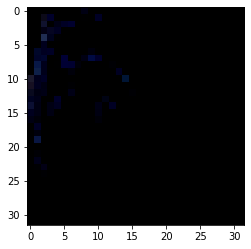

label: 7
<class 'torch.utils.data.dataloader.DataLoader'>


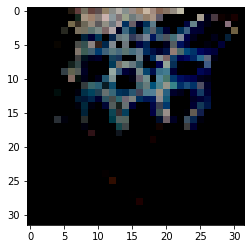

label: 8
<class 'torch.utils.data.dataloader.DataLoader'>


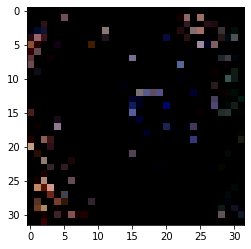

label: 6
<class 'torch.utils.data.dataloader.DataLoader'>


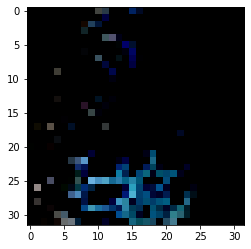

label: 7
<class 'torch.utils.data.dataloader.DataLoader'>


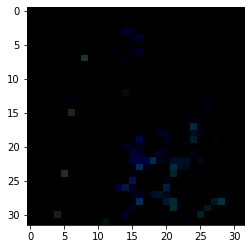

label: 6
<class 'torch.utils.data.dataloader.DataLoader'>


In [10]:
# exmaple of images
img_num = 5

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"labels batch shape: {train_labels.size()}")
for i in range(img_num):
    img = train_features[i].squeeze()
    label = train_labels[i]
    plt.imshow(img.T)
    plt.show()
    print(f"label: {label}")
    print(type(train_loader))

In [11]:
# define the network architecture
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 250)
        self.fc2 = nn.Linear(500, 250)
        # linear layer (250 -> 10)
        self.fc3 = nn.Linear(250, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        # batch normalization for convolution layer 1 output
        self.bn_conv1 = nn.BatchNorm2d(16)
        # batch normalization for convolution layer 2 output
        self.bn_conv2 = nn.BatchNorm2d(32)
        # batch normalization for convolution layer 3 output
        self.bn_conv3 = nn.BatchNorm2d(64)
        # batch noramlization for fully connected layer 1 output
        self.bn_fc1 = nn.BatchNorm1d(500) 
        # batch noramlization for fully connected layer 2 output
        self.bn_fc2 = nn.BatchNorm1d(250) 
        

    def forward(self, x):
        # add sequence of convolutional and max pooling layers (batch normalization)
        x = self.pool(F.relu(self.bn_conv1(self.conv1(x))))
        x = self.pool(F.relu(self.bn_conv2(self.conv2(x))))
        x = self.pool(F.relu(self.bn_conv3(self.conv3(x))))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with elu activation function
        x = F.relu(self.bn_fc1(self.fc1(x)))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with elu activation function
        x = F.relu(self.bn_fc2(self.fc2(x)))
        # add dropout layer
        x = self.dropout(x)
        # add 3rd layer, with elu activation function
        x = self.fc3(x)
        return x

[epoch] 1 train loss: 0.13866 train acc: 0.2309 valid loss: 0.13367 valid acc: 0.2370
[epoch] 2 train loss: 0.12378 train acc: 0.3277 valid loss: 0.12226 valid acc: 0.3185
[epoch] 3 train loss: 0.11730 train acc: 0.3724 valid loss: 0.11973 valid acc: 0.3259
[epoch] 4 train loss: 0.11478 train acc: 0.3669 valid loss: 0.11575 valid acc: 0.4000
[epoch] 5 train loss: 0.10979 train acc: 0.3929 valid loss: 0.12174 valid acc: 0.3852
[epoch] 6 train loss: 0.10950 train acc: 0.3985 valid loss: 0.11150 valid acc: 0.4148
[epoch] 7 train loss: 0.10255 train acc: 0.4562 valid loss: 0.11357 valid acc: 0.3852
[epoch] 8 train loss: 0.09913 train acc: 0.4655 valid loss: 0.10820 valid acc: 0.4444
[epoch] 9 train loss: 0.09428 train acc: 0.4842 valid loss: 0.11128 valid acc: 0.4593
[epoch] 10 train loss: 0.09451 train acc: 0.4860 valid loss: 0.09965 valid acc: 0.4815
[epoch] 11 train loss: 0.08770 train acc: 0.5400 valid loss: 0.10584 valid acc: 0.4370
[epoch] 12 train loss: 0.08919 train acc: 0.5475 val

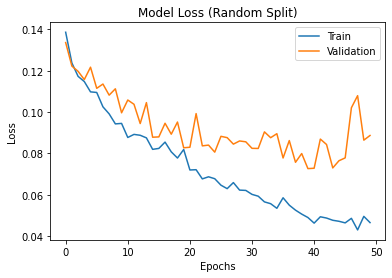

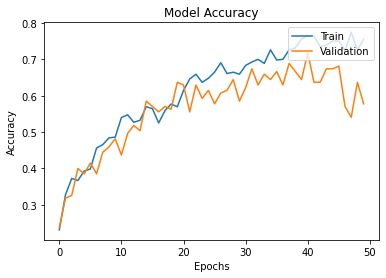

test accuracy: 62.01117318435754


array([[ 2.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.],
       [ 1., 13.,  0.,  0.,  0.,  2.,  1.,  0.,  1.,  2.],
       [ 0.,  0.,  4.,  0.,  0.,  0.,  2.,  0.,  0.,  2.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  2.],
       [ 0.,  0.,  1.,  0.,  5.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  6.,  0.,  0.,  1.,  2.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 25.,  2., 10.,  5.],
       [ 0.,  1.,  0.,  1.,  0.,  0.,  2., 21.,  7.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  5.,  1., 27.,  2.],
       [ 0.,  0.,  1.,  2.,  0.,  2.,  0.,  0.,  1.,  7.]])

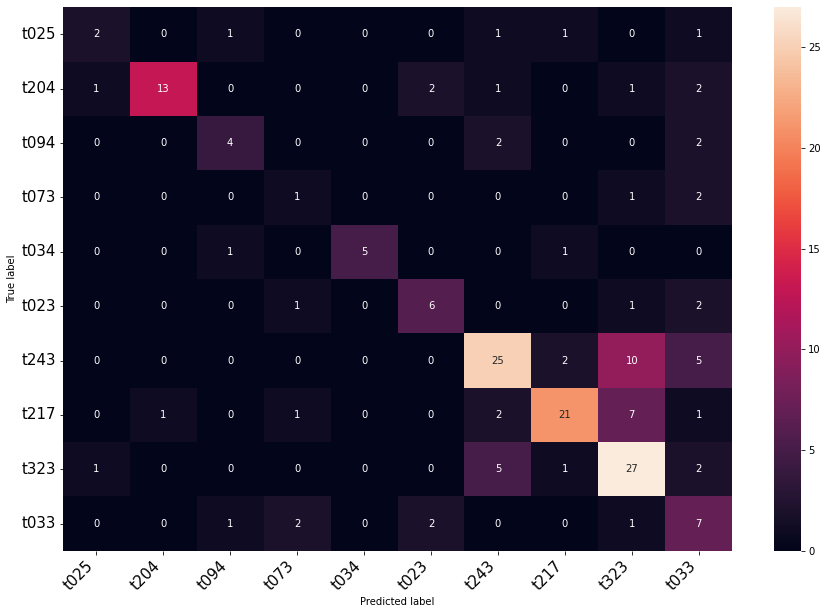

In [12]:
model = ConvNet().to(device)

# define loss and optimizer and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True)

# these lists will be used to plot the accuracy and loss against epochs
train_loss_hist, train_acc_hist = [], []
valid_loss_hist, valid_acc_hist = [], []
train_total_steps = len(train_dataset)
valid_total_steps = len(val_dataset)

# Train the model
for epoch in range(num_epochs):
    # track the training loss and the number of correct predictions from training
    train_loss = 0
    train_correct = 0
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [20, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 16 output channels, 3 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate training statistics
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

        # update the loss
        train_loss += loss.item()

    train_avg_loss = train_loss / train_total_steps
    train_avg_acc = train_correct / train_total_steps
    train_loss_hist.append(train_avg_loss)
    train_acc_hist.append(train_avg_acc)


    # Validate the model
    # turn off dropout and batch normalization
    model.eval()
    with torch.no_grad():
        valid_loss = 0
        valid_correct = 0
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # calculate training statistics
            _, predicted = torch.max(outputs, 1)
            valid_correct += (predicted == labels).sum().item()

            # update the loss
            valid_loss += loss.item()

        valid_avg_loss = valid_loss / valid_total_steps
        valid_avg_acc = valid_correct / valid_total_steps
        valid_loss_hist.append(valid_avg_loss)
        valid_acc_hist.append(valid_avg_acc)

    # turn dropout and bacth normalization back on
    model.train()

    # update learning rate
    scheduler.step(valid_avg_loss)
    print(f'[epoch] {epoch+1} train loss: {train_avg_loss:.5f} train acc: {train_avg_acc:.4f} valid loss: {valid_avg_loss:.5f} valid acc: {valid_avg_acc:.4f}')


print('Finished Training')

# Plot training statistics
if time_cutoff==False:
    plt.title('Model Loss (Random Split)')
else:    
    plt.title('Model Loss (Time-cutoff Split)')

legend = ['Train', 'Validation']
plt.plot(train_loss_hist)
plt.plot(valid_loss_hist)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper right')
plt.show()

legend = ['Train', 'Validation']
plt.plot(train_acc_hist)
plt.plot(valid_acc_hist)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper right')
plt.show()

# Save the trained model
torch.save(model.state_dict(),'checkpoint.pth')

# Download checkpoint file
model.load_state_dict(torch.load('checkpoint.pth'))

# testing the model
model.eval()
with torch.no_grad():
    nb_classes = 10
    confusion_matrix = np.zeros((nb_classes, nb_classes))
    label_list=[]
    prediction_list=[]
    for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for file in labels:
                label_list.append(file)
            for pred in preds:
                prediction_list.append(id_to_label[str(pred.item())])
            for j, k in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[j.long(), k.long()] += 1

# produce confusion matrix
plt.figure(figsize=(15,10))

unique_class_names = list(id_to_label.values())
df_cm = pd.DataFrame(confusion_matrix, index=unique_class_names, columns=unique_class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
;                    


pred_df = pd.DataFrame({'image_id': label_list, "label": prediction_list})
test_acc = 100*(pred_df['label'] == test_df['identity']).sum()/len(pred_df)
print(f'test accuracy: {test_acc}')

confusion_matrix